<a href="https://colab.research.google.com/github/tantanbei/deep-learning/blob/main/%E6%B7%B1%E5%BA%A6%E5%AD%A6%E4%B9%A0%E4%B9%8B%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E5%85%A5%E9%97%A8%E6%9C%80%E4%BD%B3%E8%B7%AF%E5%BE%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
import os
print(os.getcwd())

#The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class.
#There are 50000 training images and 10000 test images.
#下载
os.system("wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz")


/content


0

In [ ]:
#解压
os.system("tar -zxvf cifar-10-python.tar.gz")

0

In [ ]:
import _pickle as cPickle
import numpy as np
import os



CIFAR_DIR = '/content/cifar-10-batches-py'

print(os.listdir(CIFAR_DIR))

['readme.html', 'data_batch_2', 'batches.meta', 'test_batch', 'data_batch_4', 'data_batch_3', 'data_batch_5', 'data_batch_1']


In [ ]:
with open(os.path.join(CIFAR_DIR, 'data_batch_1'), 'rb') as f:

    data = cPickle.load(f, encoding='bytes')

    print('type(data):', type(data))
    print('data.keys():', data.keys())
    print("type(data[b'data']):", type(data[b'data']))
    print("type(data[b'labels']):", type(data[b'labels']))
    print("type(data[b'batch_label']):", type(data[b'batch_label']))
    print("type(data[b'filenames']):", type(data[b'filenames']))
    print("data[b'data'].shape:", data[b'data'].shape)
    print("data[b'data'][0:2]:", data[b'data'][0:2])
    print("data[b'labels'][0:2]", data[b'labels'][0:2])
    print("data[b'batch_label']", data[b'batch_label'])
    print("data[b'filenames'][0:2]", data[b'filenames'][0:2])

# 32 * 32 = 1024 * 3 = 3072
# RR－GG－BB = 3072


type(data): <class 'dict'>
data.keys(): dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
type(data[b'data']): <class 'numpy.ndarray'>
type(data[b'labels']): <class 'list'>
type(data[b'batch_label']): <class 'bytes'>
type(data[b'filenames']): <class 'list'>
data[b'data'].shape: (10000, 3072)
data[b'data'][0:2]: [[ 59  43  50 ... 140  84  72]
 [154 126 105 ... 139 142 144]]
data[b'labels'][0:2] [6, 9]
data[b'batch_label'] b'training batch 1 of 5'
data[b'filenames'][0:2] [b'leptodactylus_pentadactylus_s_000004.png', b'camion_s_000148.png']


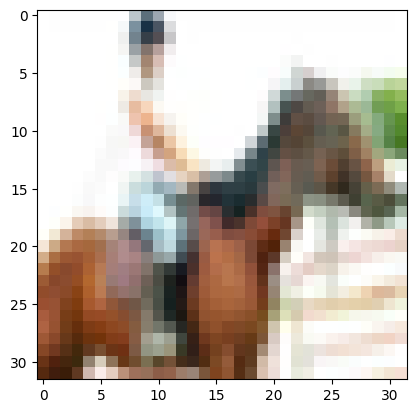

In [ ]:
image_arr = data[b'data'][131]
image_arr = image_arr.reshape((3, 32, 32))    # 32 32 3 三通道不一致，所以需要再做一下变换，如果解析的时候顺序不对，那么报错
image_arr = image_arr.transpose((1, 2, 0))    # 把1，2位置上的往前放，把0位置上的放在最后，如果通道顺序不对，那么图片的方向会发生变化

import matplotlib.pyplot as plt      # 显示图像的库
from matplotlib.pyplot import imshow

#%matplotlib inline      # 这样可以直接显示在notebook上，而不是再打开一个另外的框
imshow(image_arr)    # 显示图片

In [ ]:
# 为了使函数具有更好的泛化能力，定义一个load_data
# 用于从pickle文件将数据读取进来
def load_data(filename):
    '''read data from data file.'''
    with open(filename, 'rb') as f:
        data = cPickle.load(f, encoding='bytes')
        return data[b'data'], data[b'labels']


In [ ]:
# @title  搭建tensorflow计算图

tf.compat.v1.disable_eager_execution()

# 搭建tensorflow计算图
x = tf.compat.v1.placeholder(tf.float32, [None, 3072])     # None表示可变性

# [None]
y = tf.compat.v1.placeholder(tf.int64, [None])

# (3072, 1)
w = tf.compat.v1.get_variable('w', [x.get_shape()[-1], 1],   # 因为是二分类，所以只有一个输出结果，定义为1
                   initializer=tf.random_normal_initializer(0, 1))   #initializer表示初始化，这里使用正态分布,均值为0，方差为1

# (1, )
b = tf.compat.v1.get_variable('b', [1],
                   initializer=tf.constant_initializer(0.0))   # b使用常量初始化
# get_variable表示获取变量，如果已经定义好了就使用，如果没有就定义


# [None, 3072] * [3072, 1] = [None, 1]
y_ = tf.matmul(x, w) + b

# [None, 1]
p_y_1 = tf.nn.sigmoid(y_)   # 概率值

# 因为y维度不一样，所以需要进行一下reshape
# [None, 1]
y_reshaped = tf.reshape(y, (-1, 1))
y_reshaped_float = tf.cast(y_reshaped, tf.float32)

# 用平方差作为损失函数
loss = tf.reduce_mean(tf.square(y_reshaped_float - p_y_1))   #  类型不一致需要变换

predict = p_y_1 > 0.5    # true:1   false:0

# [1, 0, 1, 1, 0, 1,...]
correct_prediction = tf.equal(tf.cast(predict, tf.int64), y_reshaped)   # bool

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float64))

# 定义梯度下降的方法
with tf.name_scope('train_op'):
    train_op = tf.compat.v1.train.AdamOptimizer(1e-3).minimize(loss)    # 最小化loss，到这里，计算图构建完成

ValueError: Variable w already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope?

In [ ]:
# CIFAR-10数据处理的方法

class CifarData:
    # 初始化：filenames,文件名说明对于训练数据集和测试数据集是分开的
    # need_shuffle:对于训练集来说，在训练的时候，过完一遍数据之后，需要shuffle一下数据，就是使得数据更加散乱，散乱代表数据之间没有依赖关系，使得泛化能力更强，这是机器学习中一个常用的概念
    # 对于测试集来说，因为不需要训练，所以不需要shuffle
    def __init__(self, filenames, need_shuffle):
        # 把数据读进来
        all_data = []
        all_labels = []
        for filename in filenames:
            data, labels = load_data(filename)
            # 因为我们要做的是一个二分类的问题，所以我们只用CIFAR-10的0和1两个分类，在这里需要做一个filter
            # 因为data和labels的数目是一样的，所以我们把它们打包到一起
            for item, label in zip(data, labels):
                # 如果类别是0，1的话，就把数据和label放进来
                if label in [0, 1]:
                    all_data.append(item)
                    all_labels.append(label)

        # 把最后的值合并并且转化为numpy的矩阵
        self._data = np.vstack(all_data)     # 从纵向上把数据合并到一起，因为all_data定义是一个一个向量
        self._data = self._data / 127.5 - 1    # 一般来说，我们会把图像缩放到-1到1之间，所以进行缩放：归一化
        self._labels = np.hstack(all_labels)  # 从横向上合并到一起，因为label实际上是一个一维向量

        # 测试
        print(self._data.shape)
        print(self._labels.shape)

        self._num_examples = self._data.shape[0]  # 数量
        self._need_shuffle = need_shuffle   # shuffle开关
        self._indicator = 0   # 表示训练集已经遍历到哪个位置了
        if self._need_shuffle:
            self._shuffle_data()

    # 因为all_data和all_labels都是numpy的数据结构，所以我们可以用numpy的方法来做
    def _shuffle_data(self):
        # np.random.permutation这个函数会做一个混排，从0到_num_examples，如[0, 1, 2, 3, 4, 5] -> [5, 3, 2, 4, 0, 1]
        p = np.random.permutation(self._num_examples)
        # p只是得到一个排列，需要把数据放进来
        # _data和_labels应该做一样的shuffle，否则会错乱
        self._data = self._data[p]
        self._labels = self._labels[p]

    def next_batch(self, batch_size):
        '''return batch_size examples as a batch.'''
        end_indicator = self._indicator + batch_size  # 对应于_indicator，这个表示结束位置
        if end_indicator > self._num_examples:
            if self._need_shuffle:
                self._shuffle_data()
                self._indicator = 0
                end_indicator = batch_size
            else:
                raise Exception('have no more examples')

        # 当end_indicator=batch_size时，如果还比_num_examples大，就需要抛出异常了
        if end_indicator > self._num_examples:
            raise Exception('batch size is larger than all examples')

        batch_data = self._data[self._indicator: end_indicator]   # 需要把这个范围内的数据放到结果中
        batch_labels = self._labels[self._indicator: end_indicator]
        self._indicator = end_indicator
        return batch_data, batch_labels

train_filenames = [os.path.join(CIFAR_DIR, 'data_batch_%d' % i) for i in range(1,6)]
test_filenames = [os.path.join(CIFAR_DIR, 'test_batch')]

train_data = CifarData(train_filenames, True)

(10000, 3072)
(10000,)


In [ ]:
# 执行计算图，首先要初始化变量
init = tf.global_variables_initializer()

batch_size = 20
train_steps = 100000    # 因为是一个神经元，所以还是挺快的
test_steps = 100  # 20 * 200 = 2000 张图片

# 对于tensorflow来说，在构建好计算图后，需要开启一个会话session
# 打开会话之后，就可以执行计算图了
with tf.Session() as sess:

    sess.run(init)

    for i in range(train_steps):

        batch_data, batch_labels = train_data.next_batch(batch_size)

        # 在会话中执行计算图使用sess.run()方法，如果加了train_op,就说明在这次run中我们就去训练了，如果没有，就是在测试模式下
        # feed_dict:要喂入的数据，因为前面x和y都是placeholder，所以需要输入数据，x和y应该输入的是CIFAR-10的数据，分别是图片数据和label数据
        # 需要在CIFAR-10数据集上循环遍历整个数据，使得feed_dict拿到的是不同的数据
        # 为了达到这种处理模式，我们需要对CIFAR-10的数据集做一些处理
        loss_val, acc_val, _ = sess.run(
            [loss, accuracy, train_op],
            feed_dict={x: batch_data, y: batch_labels})

        # 打印log
        if (i+1) % 500 == 0:
            print('[Train] Step: %d, loss: %4.5f, acc: %4.5f' % (i+1, loss_val, acc_val))

        if (i+1) % 5000 == 0:
            # 因为test不用shuffle，所以遍历完之后抛出异常，所以需要在遍历完一次之后重新创建CifarData类
            test_data = CifarData(test_filenames, False)
            all_test_acc_val = []    # 需要做一个总的test上的结果，所以需要把这些结果加起来做平均
            for j in range(test_steps):
                test_batch_data, test_batch_labels = test_data.next_batch(batch_size)
                test_acc_val = sess.run([accuracy], feed_dict={x: test_batch_data, y: test_batch_labels})
                all_test_acc_val.append(test_acc_val)

            test_acc = np.mean(all_test_acc_val)
            print('[Test] Step: %d, acc: %4.5f' % (i+1, test_acc))

            # 两次测试准确率是一样的，说明没有学习到什么东西，我们需要做一下改进——》CifarData